In [1]:
exp <- "Flt3l"
outdir <- "/data2/mito_lineage/Analysis/annotation/output/data/"
#indir <- 
nTop = 25000

#prefix <- "CHIP_april08_2021_Croker/MTblacklist/"
#external_dat_file <- "granja_10X_CD34.rds"
#external_dat_dir <- "/data2/mito_lineage/Analysis/annotation/output/data/"

In [2]:
library(future)
plan()
#plan("multiprocess", workers = workers)
options(future.globals.maxSize = 8000 * 1024^2)

sequential:
- args: function (..., envir = parent.frame())
- tweaked: FALSE
- call: NULL

In [3]:
source("/data2/mito_lineage/R_scripts/annotations/01_CD34_projection.R")

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, ro

In [4]:
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(data.table)

library(magrittr)

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Attaching SeuratObject


Attaching package: ‘Seurat’


The following object is masked from ‘package:SummarizedExperiment’:

    Assays


Loading required package: ensembldb

Loading required package: GenomicFeatures

Loading required package: AnnotationDbi


Attaching package: ‘AnnotationDbi’


The following object is masked from ‘package:MASS’:

    select


The following object is masked from ‘package:dplyr’:

    select


Loading required package: AnnotationFilter


Attaching package: ‘AnnotationFilter’


The following object is masked from ‘package:future’:

    value



Attaching package: 'ensembldb'


The following object is masked from 'package:dplyr':

    filter


The following object is masked from 'package:stats':

    filter



Attaching package: 'patchwork'


The following object is masked from 'package:MASS':

    area



Attaching package: 'data.table'


The following objects are ma

In [5]:
# genedir <- outdir
# outdir <- file.path(outdir, prefix)
# outdir

## Import data

In [6]:
# ext <- readRDS( file.path(outdir, "granja_10X_CD34.rds"))
# curr <- readRDS(file.path(outdir, paste0(exp, ".rds")))
combined <- readRDS(file.path(outdir, paste0(exp, ".merged.rds")))

In [7]:
varPeaks <- (VariableFeatures(combined[["ATAC"]]))

In [8]:
ext <- subset(x = combined, subset = orig.ident == "granja_cd34")
curr <- subset(x = combined, subset = orig.ident == exp)


In [9]:
# Subset on varPeaks in both 
varPeaks_both <- rownames(ext)[(varPeaks %in% rownames(ext)) & (varPeaks %in% rownames(curr))]
length(varPeaks_both)
#curr_varP <- rownames(curr)[varPeaks]


[1] 673737

In [10]:
ext_var <- GetAssayData(ext)[varPeaks_both,]
dim(ext_var)

[1] 673737   2196

In [11]:
curr_var <- GetAssayData(curr)[varPeaks_both,]
dim(curr_var)

[1] 673737   5313

In [12]:
# # compute LSI
# curr <- FindTopFeatures(curr, min.cutoff = 10)
# curr <- RunTFIDF(curr)
# curr <- RunSVD(curr)

In [13]:
# # compute LSI
# ext <- FindTopFeatures(ext, min.cutoff = 10)
# ext <- RunTFIDF(ext)
# ext <- RunSVD(ext)

# Run the workflow

## 1. Run LSI 1st Iteration

In [14]:
lsi1 <- calcLSI(curr[["ATAC"]]@data, nComponents = 25, binarize = TRUE, nFeatures = NULL)
clust1 <- louvainIgraphClusters(lsi1[[1]], 10)



Binarizing matrix...

Computing Term Frequency IDF...

Computing SVD using irlba...



## 2. Make Pseudo Bulk Library


In [15]:
message("Making PseudoBulk...")
clusterSums <- groupSums(mat = curr[["ATAC"]]@data, groups = clust1) #Group Sums
logMat <- edgeR::cpm(clusterSums, log = TRUE, prior.count = 3) #log CPM matrix
varPeaks <- head(order(matrixStats::rowVars(logMat), decreasing = TRUE), nTop) #Top variable peaks
dim(varPeaks)

Making PseudoBulk...



NULL

## 3. Run LSI 2nd Iteration

In [16]:
lsi2 <- calcLSI(curr[["ATAC"]]@data[varPeaks,,drop=FALSE], nComponents = 25, binarize = TRUE, nFeatures = NULL)
clust2 <- louvainIgraphClusters(lsi2[[1]][,c(2:25)], 30)
print("Number of clusters")
print(length(unique(clust2)))
print("LSI2 dimensions")
print(dim(lsi2$matSVD))


Binarizing matrix...

Computing Term Frequency IDF...

Computing SVD using irlba...



[1] "Number of clusters"
[1] 8
[1] "LSI2 dimensions"
[1] 5313   25


### build mean for clusters

In [17]:
means_lsi <- build_means_for_clusters(lsi2$matSVD, clust2)
lsiPeaks <- varPeaks
lsiReference <- lsi2


## Run UMAP on 2nd LSI

In [18]:
set.seed(1)
umap <- umap::umap(
  lsi2$matSVD[,2:25], 
  n_neighbors = 55, # original 55
  min_dist = 0.45, # original 0.45
  metric = "cosine", 
  verbose = TRUE    )
#set.seed(10)

[2021-07-28 00:14:59]  starting umap

[2021-07-28 00:14:59]  creating graph of nearest neighbors

[2021-07-28 00:16:08]  creating initial embedding

[2021-07-28 00:16:10]  optimizing embedding

[2021-07-28 00:16:29]  done



In [19]:
umap_clust2 <- louvainIgraphClusters(umap$layout, k = 100)
length(unique(umap_clust2))
umap_means_lsi <- build_means_for_clusters(umap$layout, umap_clust2)

[1] 12

## Project external data to our space

In [20]:
lsiProjection <- projectLSI(ext[["ATAC"]]@data[varPeaks,,drop=FALSE], lsi2)


Binarizing matrix...

Computing Term Frequency IDF...

Computing SVD using irlba...



In [21]:
noZero.inds <- names(which(!((apply(data.matrix(lsiProjection[,2:25]==0),MARGIN=1, all)))))
umapProjection <- round(predict(umap, data.matrix(lsiProjection[noZero.inds,2:25])), 2)
#umapProjection <- round(predict(umap, data.matrix(lsiProjection[,2:25])), 2)

[2021-07-28 00:16:34]  creating graph of nearest neighbors

[2021-07-28 00:18:10]  creating initial embedding

[2021-07-28 00:18:10]  optimizing embedding

[2021-07-28 00:18:13]  done



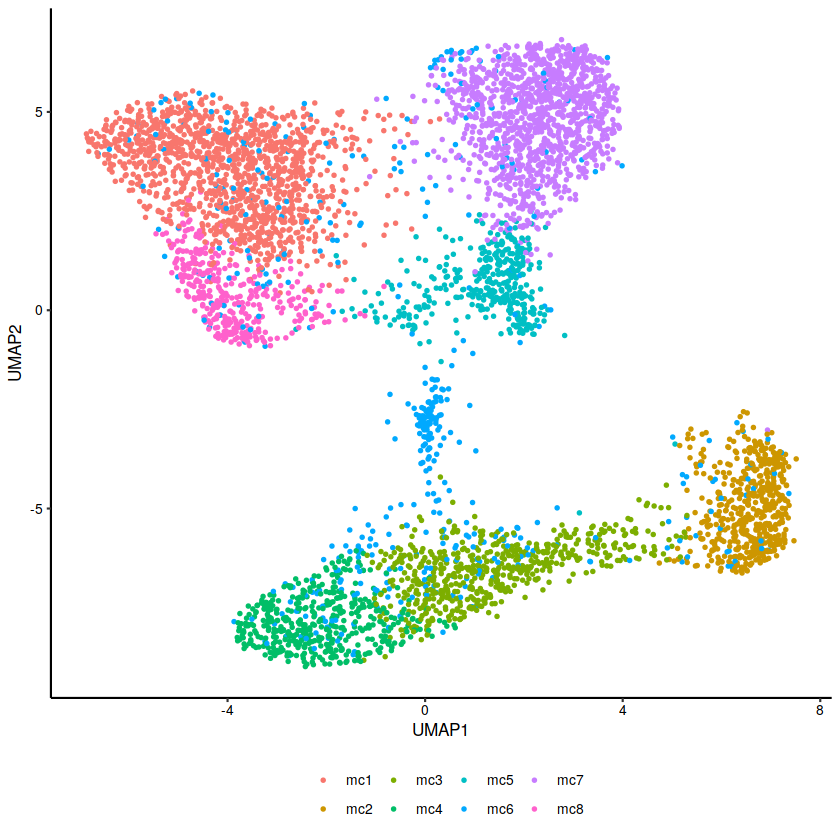

In [22]:
# Multiply by -1 to make the pseudotime read left to right
plot_df <- data.frame(umap$layout*-1, (curr[[]]), Clusters = clust2)

p0 <- ggplot(plot_df, aes(x= X1, y = X2, color = Clusters)) +
   geom_point(size = 0.5) +
   labs(x = "UMAP1", y= "UMAP2", color = "") +
  pretty_plot() + L_border() + theme(legend.position = "bottom")

print(p0)

In [23]:
# external_dat_dir <- "/data2/mito_lineage/Analysis/annotation/output/data/granja_cd34"
# external_prefix <- "GSE129785_scATAC-Hematopoiesis-CD34"


# barcode_path <- file.path(external_dat_dir, paste0(external_prefix, ".cell_barcodes.txt"))


# metadata <- read.csv(
#   file = file.path(external_dat_dir, paste0(external_prefix, ".cell_barcodes.txt")),
#   header = TRUE,
#   sep='\t',
# )
# #CD34boo <- colData$Group %in% c("CD34_Progenitors_Rep1","CD34_Progenitors_Rep2")
# c1boo <-  metadata$Group %in% c("BM_pDC", "CLP", "CMP", "GMP", "HSC", "LMPP", "MEP", "Monocytes", "MPP")
# metadata <- metadata[c1boo,]

# rownames(metadata) <- metadata$Group_Barcode
# metadata$proj <- "granja_cd34"
# cell_names <- rownames(metadata)
# metadata <- metadata[,c("Group", "proj")]
# rownames(metadata) <- lapply(rownames(metadata), function(x) paste0("ext_",x))

# metadata


# sext <- AddMetaData(ext, metadata)

In [24]:
projection_df <- data.frame(
  celltype = c(gsub("BM_", "", (ext[[]])[rownames(umapProjection),]$Group), rep("none", dim(plot_df)[1])),
  umap1 = c(umapProjection[,1]*-1, plot_df$X1),
  umap2 = c(umapProjection[,2]*-1, plot_df$X2)
)


Warning message:
"Removed 122 rows containing missing values (geom_point)."


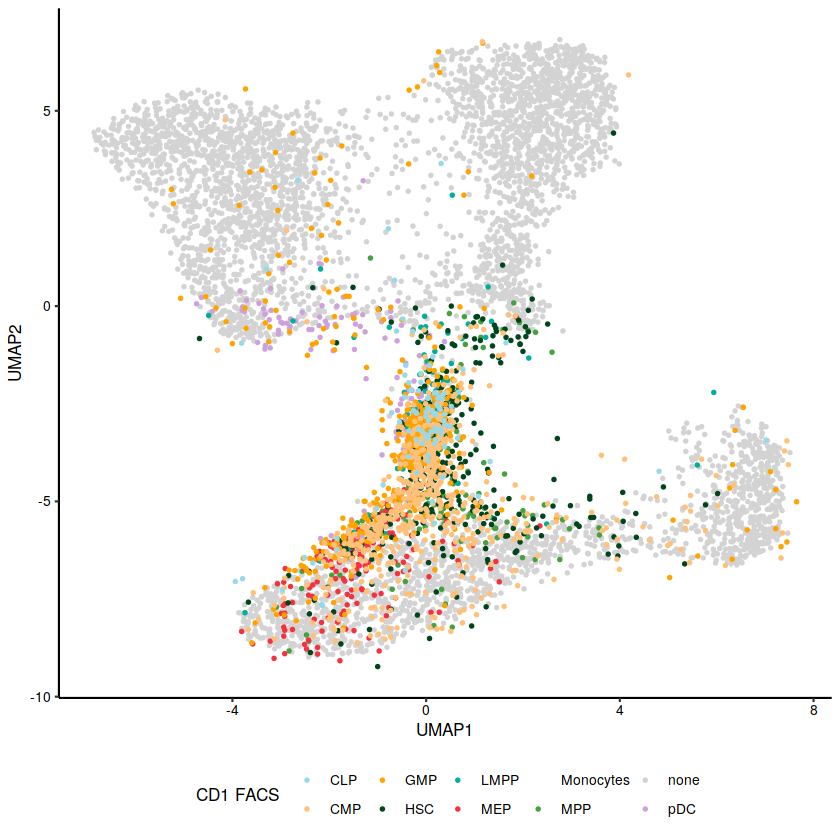

In [25]:
p1 <- ggplot(projection_df[dim(projection_df)[1]:1,], aes(x= umap1, y = umap2, color = celltype, label = celltype)) +
  geom_point(size = 0.5) +
  labs(x = "UMAP1", y= "UMAP2", color = "CD1 FACS ") +
  pretty_plot() + L_border() + theme(legend.position = "bottom") +
  scale_color_manual(values = c(ejc_color_maps, "none" = "lightgrey"))#, "Monocytes" = "orange2")) 
print(p1)



## LSI Project and classify 
(Also try the umap project and classify

In [26]:
## Classifying each cluster to nearest reference cell
use_means <- FALSE
if(use_means){
    projected_clustersbasic <- classify_from_reference(data.matrix(lsiProjection)[rownames(umapProjection),1:25],t(means_lsi)[,1:25])    
}else{
    ## Classifying each cell to nearest reference cell.
    projected_clustersbasic <- classify_from_reference(data.matrix(lsiProjection)[rownames(umapProjection),1:25],
                                                   (lsi2$matSVD)[,1:25])    
}
head(projected_clustersbasic)


                                                   



[1] "ext_CMP#20160726_scATAC_BM1214_CMP_LS_88" 
[2] "ext_CMP#160822_BM1137_CMP_LS_92"          
[3] "ext_GMP#160808_scATAC_BM1137_GMP2mid_LS_6"
[4] "ext_GMP#BM1214_GMP_160421_55"             
[5] "ext_GMP#160808_scATAC_BM1137_GMP2mid_LS_6"
[6] "ext_CMP#160819_BM1137_CMP_LS_22"

In [27]:
#annovec <- c("myeloid", "myeloid", "CD4", "CD4", "Bcell", "CD8", "myeloid", "myeloid", "myeloid", "NKcell", "CD4", "CD8", "Bcell")
annovec <- ext[["Group"]]
#names(annovec) <- paste0("mc", as.character(1:13))
projected_clusters <- annovec[as.character(projected_clustersbasic),]
projected_clusters
curr[["predict"]] <- projected_clusters

group_or_pred <- function(x){
    if (is.na(x["Group"])){
      return(x["predict"])
    }
    return(x["Group"])
    
    }
curr[["group_or_predict"]] <- apply(curr[[]], MARGIN=1, group_or_pred)

[1] "CMP"       "CMP"       "GMP"       "GMP"       "GMP"       "CMP"      
   [7] "GMP"       "GMP"       "GMP"       "GMP"       "CMP"       "CMP"      
  [13] "GMP"       "GMP"       "GMP"       "BM_pDC"    "Monocytes" "GMP"      
  [19] "BM_pDC"    "GMP"       "GMP"       "MEP"       "GMP"       "MEP"      
  [25] "GMP"       "CMP"       "CMP"       "GMP"       "CMP"       "CMP"      
  [31] "BM_pDC"    "MEP"       "MEP"       "CMP"       "MEP"       "GMP"      
  [37] "MEP"       "GMP"       "CMP"       "BM_pDC"    "GMP"       "GMP"      
  [43] "GMP"       "MEP"       "BM_pDC"    "GMP"       "MEP"       "MEP"      
  [49] "GMP"       "MEP"       "CMP"       "Monocytes" "MEP"       "BM_pDC"   
  [55] "MEP"       "GMP"       "GMP"       "LMPP"      "HSC"       "GMP"      
  [61] "CMP"       "GMP"       "MEP"       "HSC"       "GMP"       "GMP"      
  [67] "GMP"       "CMP"       "LMPP"      "CMP"       "MEP"       "MEP"      
  [73] "CMP"       "MEP"       "GMP"       "GMP"       "GMP"       "GMP"      
  [79] "GMP"       "MEP"       "MEP"       "MEP"       "MEP"       "GMP"      
  [85] "CMP"       "GMP"       "GMP"       "CMP"       "CMP"       "CMP"      
  [91] "MEP"       "MPP"       "GMP"       "GMP"       "CMP"       "CMP"      
  [97] "GMP"       "GMP"       "GMP"       "CMP"       "CMP"       "MEP"      
 [103] "GMP"       "GMP"       "GMP"       "GMP"       "MEP"       "BM_pDC"   
 [109] "GMP"       "MEP"       "CMP"       "MEP"       "GMP"       "GMP"      
 [115] "BM_pDC"    "Monocytes" "GMP"       "GMP"       "GMP"       "GMP"      
 [121] "MEP"       "CMP"       "GMP"       "MEP"       "GMP"       "GMP"      
 [127] "BM_pDC"    "CMP"       "GMP"       "GMP"       "GMP"       "MEP"      
 [133] "CMP"       "CMP"       "HSC"       "GMP"       "GMP"       "MEP"      
 [139] "GMP"       "GMP"       "GMP"       "LMPP"      "GMP"       "MEP"      
 [145] "BM_pDC"    "CMP"       "GMP"       "GMP"       "GMP"       "GMP"      
 [151] "MEP"       "GMP"       "GMP"       "GMP"       "MEP"       "BM_pDC"   
 [157] "LMPP"      "GMP"       "CMP"       "MEP"       "GMP"       "CMP"      
 [163] "GMP"       "GMP"       "BM_pDC"    "CMP"       "GMP"       "MEP"      
 [169] "CMP"       "GMP"       "CMP"       "GMP"       "BM_pDC"    "MEP"      
 [175] "GMP"       "GMP"       "GMP"       "GMP"       "CMP"       "GMP"      
 [181] "CMP"       "GMP"       "BM_pDC"    "MEP"       "GMP"       "MEP"      
 [187] "GMP"       "MEP"       "GMP"       "MEP"       "CMP"       "MEP"      
 [193] "MEP"       "GMP"       "MEP"       "GMP"       "MPP"       "MEP"      
 [199] "GMP"       "GMP"       "GMP"       "Monocytes" "MEP"       "CMP"      
 [205] "GMP"       "MEP"       "MEP"       "GMP"       "LMPP"      "CMP"      
 [211] "BM_pDC"    "CMP"       "BM_pDC"    "GMP"       "MEP"       "GMP"      
 [217] "CMP"       "CMP"       "GMP"       "CMP"       "GMP"       "GMP"      
 [223] "GMP"       "CMP"       "CMP"       "CMP"       "GMP"       "GMP"      
 [229] "GMP"       "MEP"       "GMP"       "MEP"       "CMP"       "GMP"      
 [235] "CMP"       "MEP"       "GMP"       "MEP"       "BM_pDC"    "GMP"      
 [241] "BM_pDC"    "CMP"       "GMP"       "CMP"       "GMP"       "Monocytes"
 [247] "GMP"       "MEP"       "CMP"       "MEP"       "MEP"       "HSC"      
 [253] "GMP"       "GMP"       "HSC"       "MEP"       "GMP"       "CMP"      
 [259] "GMP"       "GMP"       "GMP"       "GMP"       "GMP"       "CMP"      
 [265] "GMP"       "GMP"       "MEP"       "GMP"       "GMP"       "MEP"      
 [271] "GMP"       "Monocytes" "MEP"       "MEP"       "CMP"       "LMPP"     
 [277] "LMPP"      "GMP"       "MEP"       "CMP"       "GMP"       "CMP"      
 [283] "GMP"       "CMP"       "CMP"       "GMP"       "GMP"       "CMP"      
 [289] "GMP"       "HSC"       "LMPP"      "GMP"       "GMP"       "GMP"      
 [295] "GMP"       "MEP"       "HSC"       "GMP"       "GMP"       "BM_pDC"   
 [301] "CMP"       "MEP"       "CMP"       "MEP"     

In [28]:
curr[["group_or_predict"]] <- apply(curr[[]], MARGIN=1, group_or_pred)

In [29]:
plot_df <- data.frame(umap$layout*-1, (curr[[]]), Clusters = clust2)
projection_df <- data.frame(
  celltype = c(gsub("BM_", "", (ext[[]])[rownames(umapProjection),]$Group), 
               plot_df[,"group_or_predict"]),
  umap1 = c(umapProjection[,1]*-1, plot_df$X1),
  umap2 = c(umapProjection[,2]*-1, plot_df$X2)
)
head(projection_df)

,celltype,umap1,umap2
,<chr>,<dbl>,<dbl>
1,Monocytes,-4.56,0.98
2,Monocytes,-4.32,-0.47
3,Monocytes,0.09,-3.75
4,Monocytes,-2.96,-0.82
5,Monocytes,-0.60,-3.30
6,Monocytes,-1.61,-0.54


Warning message:
"Removed 495 rows containing missing values (geom_point)."


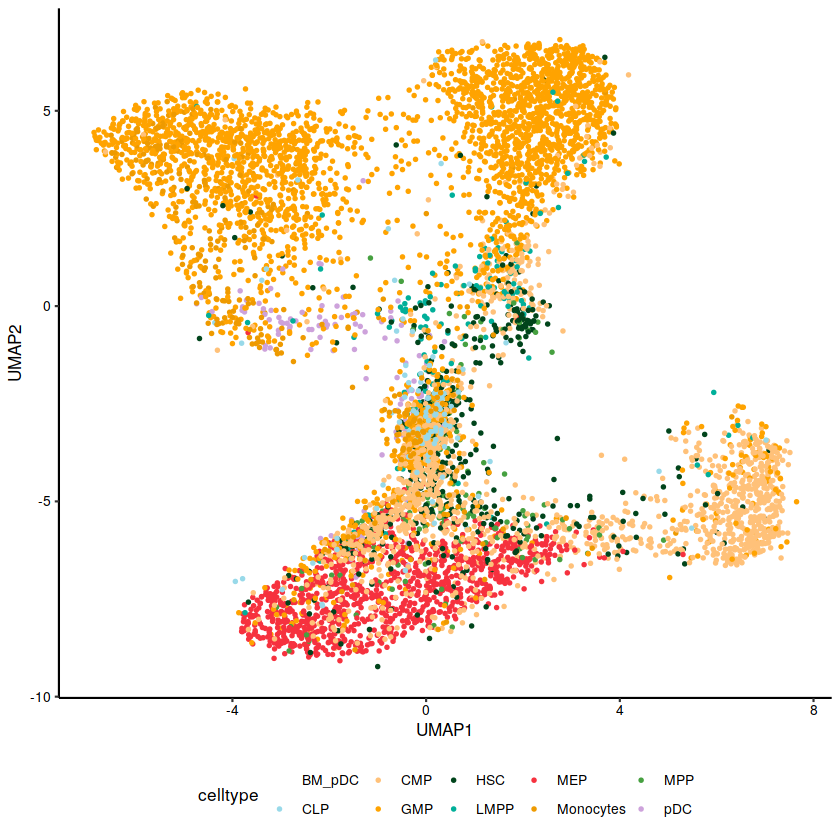

In [30]:
p1 <- ggplot(projection_df[dim(projection_df)[1]:1,], aes(x= umap1, y = umap2, color = celltype, label = celltype)) +
  geom_point(size = 0.5) +
  labs(x = "UMAP1", y= "UMAP2", color="celltype") +
  pretty_plot() + L_border() + theme(legend.position = "bottom") +
  scale_color_manual(values = c(ejc_color_maps, "none" = "lightgrey","Monocytes" = "orange2")) 
print(p1)



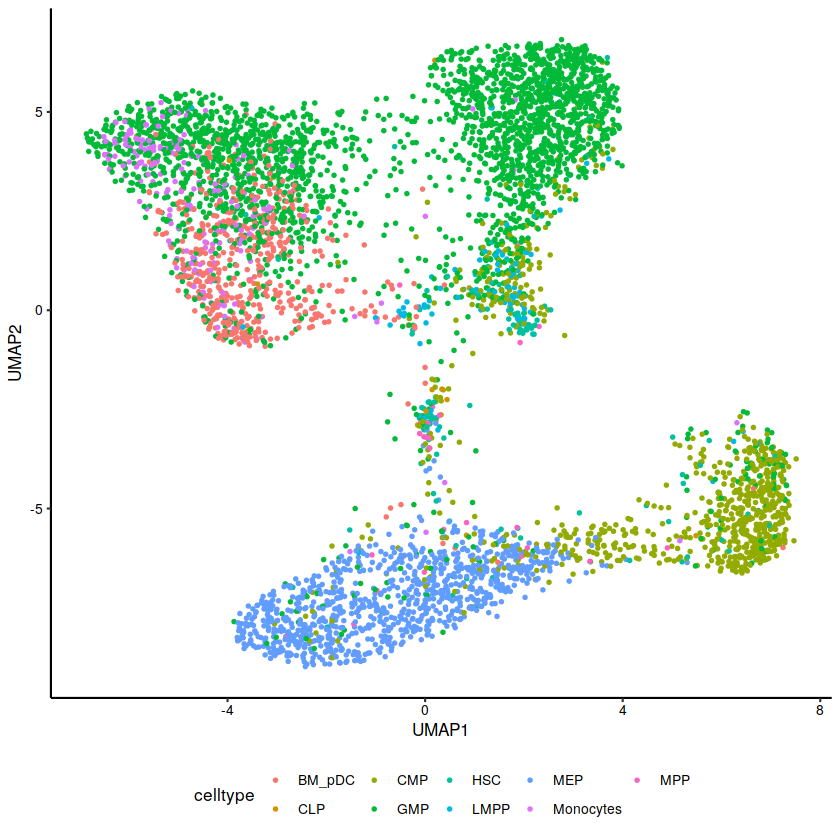

In [31]:
# Multiply by -1 to make the pseudotime read left to right
plot_df <- data.frame(umap$layout*-1, (curr[[]]))

p0 <- ggplot(plot_df, aes(x= X1, y = X2, color = group_or_predict)) +
   geom_point(size = 0.5) +
   labs(x = "UMAP1", y= "UMAP2", color = "celltype") +
  pretty_plot() + L_border() + theme(legend.position = "bottom")


print(p0)

          predict
orig.ident BM_pDC  CLP  CMP  GMP  HSC LMPP  MEP Monocytes  MPP
     Flt3l    495   13  848 2591  121   89  929       200   27

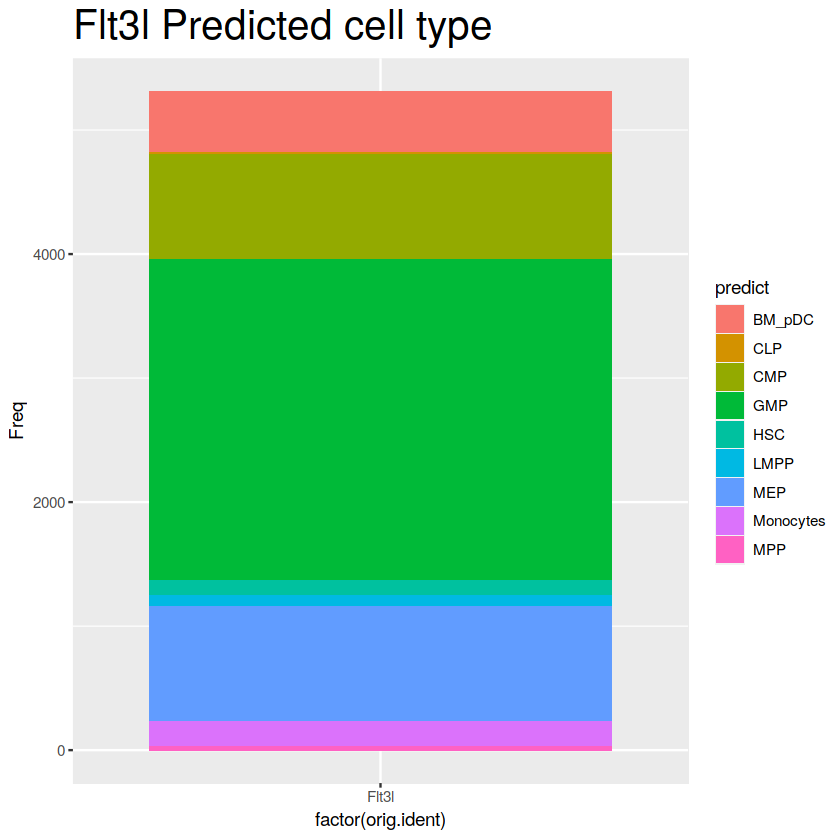

In [33]:
tbl <- with(plot_df, table(orig.ident, predict))
tbl
ggplot(as.data.frame(tbl), aes(factor(orig.ident), Freq, fill = predict)) +
    geom_bar(position = 'stack', stat='identity') +
    ggtitle(paste(exp, "Predicted cell type")) + 
    theme(plot.title=element_text(size=24))

## Save

In [69]:
write.table(projection_df, file = file.path(outdir, paste0(exp, ".extProjection.txt")), quote=F)

In [68]:
write.table(plot_df, file = file.path(outdir, paste0(exp, "_umapProjection.txt")),quote=F)

In [58]:
write.table(plot_df[, "predict", drop=FALSE], file = file.path(outdir, paste0(exp, ".clusters.txt")), col.names=FALSE,
          row.names=TRUE, quote=FALSE, sep=",")